# Data prep

In [ ]:
!pip install datasets faiss-gpu langchain-community ragatouille

In [ ]:
import datasets
import pandas as pd

doc_dataset = datasets.load_dataset("m-ric/huggingface_doc", split="train")
qa_dataset = datasets.load_dataset("m-ric/huggingface_doc_qa_eval", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
doc_df = pd.DataFrame(doc_dataset)
qa_df = pd.DataFrame(qa_dataset)

In [ ]:
pd.set_option('display.max_colwidth', 100)
#pd.set_option('display.max_colwidth', None)

In [ ]:
len(doc_df[doc_df['source']=='huggingface/tokenizers/blob/main/bindings/node/npm/linux-x64-musl/README.md']['text'].iloc[0])

96

In [ ]:
len(qa_df.iloc[0]['context'])

96

In [ ]:
doc_df.head()

,text,source
0,"Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation pa...",huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx
1,Choosing a metric for your task\n\n**So you've trained your model and want to see how well it’s...,huggingface/evaluate/blob/main/docs/source/choosing_a_metric.mdx
2,主要特点\n\n让我们来介绍一下 Gradio 最受欢迎的一些功能！这里是 Gradio 的主要特点：\n\n1. [添加示例输入](#example-inputs)\n2. [传递自定义错...,gradio-app/gradio/blob/main/guides/cn/01_getting-started/02_key-features.md
3,!--Copyright 2023 The HuggingFace Team. All rights reserved.\n\nLicensed under the Apache Licens...,huggingface/transformers/blob/main/docs/source/en/perf_train_tpu_tf.md
4,Gradio Demo: blocks_random_slider\n\n\n```\n!pip install -q gradio \n```\n\n\n```\n\nimport gra...,gradio-app/gradio/blob/main/demo/blocks_random_slider/run.ipynb


In [ ]:
qa_df.head()

,context,question,answer,source_doc,standalone_score,standalone_eval,relatedness_score,relatedness_eval,relevance_score,relevance_eval
0,`tokenizers-linux-x64-musl`\n\nThis is the **...,What architecture is the `tokenizers-linux-x64...,x86_64-unknown-linux-musl,huggingface/tokenizers/blob/main/bindings/node...,5,The question is asking about the specific arch...,5,The context directly specifies the architectur...,3,The question is asking for specific technical ...
1,!--Copyright 2023 The HuggingFace Team. All ri...,What is the purpose of the BLIP-Diffusion mode...,The BLIP-Diffusion model is designed for contr...,huggingface/diffusers/blob/main/docs/source/en...,5,The question is asking for the purpose of a sp...,5,The context provides a detailed description of...,3,The question asks about the purpose of the BLI...
2,Paper Pages\n\nPaper pages allow people to fi...,How can a user claim authorship of a paper on ...,By clicking their name on the corresponding Pa...,huggingface/hub-docs/blob/main/docs/hub/paper-...,5,The question is clear and does not depend on a...,5,The context provides a clear explanation of ho...,3,The question is specific to the Hugging Face H...
3,Datasets server API\n\n> API on 🤗 datasets\n\...,What is the purpose of the /healthcheck endpoi...,Ensure the app is running,huggingface/datasets-server/blob/main/services...,5,The question is asking for the purpose of a sp...,5,The context directly states the purpose of the...,4,"The question is specific and technical, asking..."
4,!--Copyright 2022 The HuggingFace Team. All ri...,What is the default context window size for Lo...,127 tokens,huggingface/transformers/blob/main/docs/source...,5,The question is asking for a specific paramete...,5,The context provides a specific detail about t...,3,"This question is specific and technical, askin..."


In [ ]:
from langchain.docstore.document import Document as LangchainDocument
from tqdm.notebook import tqdm

In [ ]:
RAW_KB = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(doc_dataset)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

# Chunking

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import Optional, List, Tuple
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain.docstore.document import Document as LangchainDocument
from tqdm.notebook import tqdm

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

# Experiment embedding model, subject to change
EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in tqdm(RAW_KB, desc="Processing documents"):
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique

In [ ]:
docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KB,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

Processing documents:   0%|          | 0/2647 [00:00<?, ?it/s]

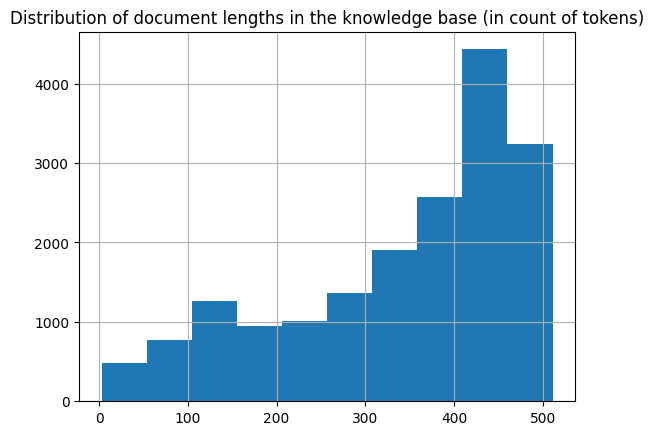

In [ ]:
# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [ ]:
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

<ipython-input-6-b0c7b39a7f62>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


In [ ]:
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
# Save the FAISS index
KNOWLEDGE_VECTOR_DATABASE.save_local("faiss_index")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Later, to load it back:
KNOWLEDGE_VECTOR_DATABASE = FAISS.load_local(
    "/content/drive/MyDrive/rag-embeddings",
    embeddings=embedding_model,
    allow_dangerous_deserialization=True
)

In [ ]:
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [ ]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [ ]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [ ]:
from tqdm import tqdm
from typing import List, Dict

def evaluate_retriever(
    vectorstore: FAISS,
    qa_dataset: datasets.arrow_dataset.Dataset,
    k: int = 5
) -> Dict:
    """
    Evaluate retriever performance by checking if source documents are in top-k retrieved docs

    Args:
        vectorstore: FAISS vectorstore
        qa_dataset: Dataset with question/answer pairs and source docs
        k: Number of documents to retrieve

    Returns:
        Dict with metrics including hit rate and position analysis
    """
    total = len(qa_dataset)
    hits = 0
    position_hits = [0] * k  # Track which position had the hit

    for item in tqdm(qa_dataset):
        # Get retrieved documents
        retrieved_docs = vectorstore.similarity_search(
            item['question'],
            k=k
        )

        # Get document IDs from retrieved docs
        retrieved_ids = [doc.metadata.get('source', '') for doc in retrieved_docs]

        # Check if source doc is in retrieved docs
        if item['source_doc'] in retrieved_ids:
            hits += 1
            # Record position of hit (0-based index)
            position_hits[retrieved_ids.index(item['source_doc'])] += 1

    metrics = {
        'total_queries': total,
        'hits': hits,
        'hit_rate': hits/total,
        'position_distribution': {
            f'position_{i+1}': count/hits if hits > 0 else 0
            for i, count in enumerate(position_hits)
        }
    }

    return metrics

# Run evaluation
metrics = evaluate_retriever(KNOWLEDGE_VECTOR_DATABASE, qa_dataset.select(range(10)))

# Print results
print(f"Retrieval Evaluation Results:")
print(f"Total Queries: {metrics['total_queries']}")
print(f"Hit Rate @ {10}: {metrics['hit_rate']:.2%}")
print("\nPosition Distribution of Hits:")
for pos, rate in metrics['position_distribution'].items():
    print(f"{pos}: {rate:.2%}")

100%|██████████| 10/10 [02:00<00:00, 12.09s/it]

Retrieval Evaluation Results:
Total Queries: 10
Hit Rate @ 5: 80.00%

Position Distribution of Hits:
position_1: 50.00%
position_2: 12.50%
position_3: 37.50%
position_4: 0.00%
position_5: 0.00%


In [ ]:
type(qa_dataset.select(range(3)))

datasets.arrow_dataset.Dataset

In [ ]:
KNOWLEDGE_VECTOR_DATABASE.similarity_search(user_query, k=3)

[Document(metadata={'source': 'huggingface/diffusers/blob/main/docs/source/en/api/pipelines/deepfloyd_if.md', 'start_index': 16887}, page_content='```\n\n## Available Pipelines:'),
 Document(metadata={'source': 'huggingface/transformers/blob/main/docs/source/en/quicktour.md', 'start_index': 1585}, page_content='```\n</tf>\n</frameworkcontent>\n\n## Pipeline\n\n<Youtube id="tiZFewofSLM"/>\n\nThe [`pipeline`] is the easiest and fastest way to use a pretrained model for inference. You can use the [`pipeline`] out-of-the-box for many tasks across different modalities, some of which are shown in the table below:\n\n<Tip>\n\nFor a complete list of available tasks, check out the [pipeline API reference](./main_classes/pipelines).\n\n</Tip>'),
 Document(metadata={'source': 'huggingface/diffusers/blob/main/docs/source/en/using-diffusers/conditional_image_generation.md', 'start_index': 1874}, page_content='```\n\n2. Pass a prompt to the pipeline to generate an image:\n\n```py\nimage = pipeline(\

In [ ]:
len(KNOWLEDGE_VECTOR_DATABASE.docstore._dict)

17995

# Reranking strategy

In [ ]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")


artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [ ]:
from tqdm import tqdm
from typing import List, Dict, Optional
from ragatouille import RAGPretrainedModel
import time

def evaluate_retriever(
    vectorstore: FAISS,
    qa_dataset: datasets.arrow_dataset.Dataset,
    k: int = 5,
    use_colbert_reranking: bool = False,
    colbert_model: Optional[RAGPretrainedModel] = None
) -> Dict:
    """
    Evaluate retriever performance with configurable retrieval strategies

    Args:
        vectorstore: FAISS vectorstore
        qa_dataset: Dataset with question/answer pairs and source docs
        k: Number of documents to retrieve
        use_colbert_reranking: Whether to apply ColBERTv2 reranking
        colbert_model: Pre-initialized ColBERTv2 model (required if use_colbert_reranking=True)

    Returns:
        Dict with metrics including hit rate, position analysis, and latency
    """
    total = len(qa_dataset)
    hits = 0
    position_hits = [0] * k
    total_latency = 0

    # Validate ColBERT configuration
    if use_colbert_reranking and colbert_model is None:
        raise ValueError("ColBERT reranking enabled but no model provided")

    for item in tqdm(qa_dataset):
        start_time = time.time()

        # Initial retrieval with FAISS
        retrieved_docs = vectorstore.similarity_search(
            item['question'],
            k=k if not use_colbert_reranking else k * 2  # Retrieve more docs if using reranking
        )

        # Apply ColBERT reranking if enabled
        if use_colbert_reranking:
            # Prepare documents for reranking
            docs_for_reranking = [doc.page_content for doc in retrieved_docs]

            # Rerank with ColBERT
            reranked_results = colbert_model.rerank(
                query=item['question'],
                documents=docs_for_reranking,
                k=k
            )

            # Create new list of documents based on reranked results
            reranked_docs = []
            for result in reranked_results:
                # Find original doc that matches this content
                for doc in retrieved_docs:
                    if doc.page_content == result['content']:
                        reranked_docs.append(doc)
                        break
            retrieved_docs = reranked_docs[:k]

        # Calculate latency
        latency = time.time() - start_time
        total_latency += latency

        # Get document IDs from retrieved docs
        retrieved_ids = [doc.metadata.get('source', '') for doc in retrieved_docs]

        # Check if source doc is in retrieved docs
        if item['source_doc'] in retrieved_ids:
            hits += 1
            position_hits[retrieved_ids.index(item['source_doc'])] += 1

    metrics = {
        'configuration': {
            'retrieval_method': 'faiss_with_colbert' if use_colbert_reranking else 'faiss',
            'k': k
        },
        'performance': {
            'total_queries': total,
            'hits': hits,
            'hit_rate': hits/total,
            'avg_latency': total_latency/total,
            'position_distribution': {
                f'position_{i+1}': count/hits if hits > 0 else 0
                for i, count in enumerate(position_hits)
            }
        }
    }

    return metrics

In [ ]:
# Run evaluations with different configurations
base_metrics = evaluate_retriever(
    KNOWLEDGE_VECTOR_DATABASE,
    qa_dataset.select(range(10)),
    k=5,
    use_colbert_reranking=False
)

100%|██████████| 10/10 [01:27<00:00,  8.73s/it]


In [ ]:
colbert_metrics = evaluate_retriever(
    KNOWLEDGE_VECTOR_DATABASE,
    qa_dataset.select(range(10)),
    k=5,
    use_colbert_reranking=True,
    colbert_model=RERANKER
)

100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


In [ ]:
# Print comparison
def print_comparison(base_metrics, colbert_metrics):
    print("Comparison of Retrieval Strategies:")
    print("-" * 50)
    print(f"{'Metric':<20} {'Base':<15} {'With ColBERT':<15}")
    print("-" * 50)
    print(f"Hit Rate @ {5:<14} {base_metrics['performance']['hit_rate']:.2%} {colbert_metrics['performance']['hit_rate']:.2%}")
    print(f"Avg Latency (s){'':<8} {base_metrics['performance']['avg_latency']:.3f} {colbert_metrics['performance']['avg_latency']:.3f}")

    print("\nPosition Distribution:")
    for pos in range(5):
        base_dist = base_metrics['performance']['position_distribution'][f'position_{pos+1}']
        colbert_dist = colbert_metrics['performance']['position_distribution'][f'position_{pos+1}']
        print(f"Position {pos+1:<12} {base_dist:.2%} {colbert_dist:.2%}")

print_comparison(base_metrics, colbert_metrics)

Comparison of Retrieval Strategies:
--------------------------------------------------
Metric               Base            With ColBERT   
--------------------------------------------------
Hit Rate @ 5              80.00% 80.00%
Avg Latency (s)         8.726 9.330

Position Distribution:
Position 1            50.00% 75.00%
Position 2            12.50% 12.50%
Position 3            37.50% 0.00%
Position 4            0.00% 12.50%
Position 5            0.00% 0.00%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_retrieval_metrics(*metrics_dicts, figsize=(15, 10)):
    """
    Visualize retrieval metrics for multiple configurations.

    Args:
        *metrics_dicts: Variable number of metrics dictionaries from evaluate_retriever
        figsize: Tuple specifying figure dimensions
    """
    num_configs = len(metrics_dicts)
    config_names = [m['configuration']['retrieval_method'] for m in metrics_dicts]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Retrieval Configuration Comparison', fontsize=16, y=0.95)

    # Colors for different configurations
    colors = plt.cm.tab10(np.linspace(0, 1, num_configs))

    # 1. Hit Rate Bar Plot
    hit_rates = [m['performance']['hit_rate'] * 100 for m in metrics_dicts]
    ax1.bar(config_names, hit_rates, color=colors)
    ax1.set_title('Hit Rate')
    ax1.set_ylabel('Hit Rate (%)')
    ax1.grid(True, alpha=0.3)

    # 2. Average Latency Bar Plot
    latencies = [m['performance']['avg_latency'] for m in metrics_dicts]
    ax2.bar(config_names, latencies, color=colors)
    ax2.set_title('Average Latency')
    ax2.set_ylabel('Time (seconds)')
    ax2.grid(True, alpha=0.3)

    # 3. Position Distribution Line Plot
    ax3.set_title('Position Distribution of Hits')
    for i, metrics in enumerate(metrics_dicts):
        positions = range(1, len(metrics['performance']['position_distribution']) + 1)
        distributions = [metrics['performance']['position_distribution'][f'position_{p}'] * 100
                        for p in positions]
        ax3.plot(positions, distributions, 'o-',
                 label=config_names[i], color=colors[i], linewidth=2)
    ax3.set_xlabel('Position')
    ax3.set_ylabel('Percentage of Hits (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Cumulative Position Distribution
    ax4.set_title('Cumulative Position Distribution')
    for i, metrics in enumerate(metrics_dicts):
        positions = range(1, len(metrics['performance']['position_distribution']) + 1)
        distributions = [metrics['performance']['position_distribution'][f'position_{p}'] * 100
                        for p in positions]
        cumulative = np.cumsum(distributions)
        ax4.plot(positions, cumulative, 'o-',
                 label=config_names[i], color=colors[i], linewidth=2)
    ax4.set_xlabel('Position')
    ax4.set_ylabel('Cumulative Percentage (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

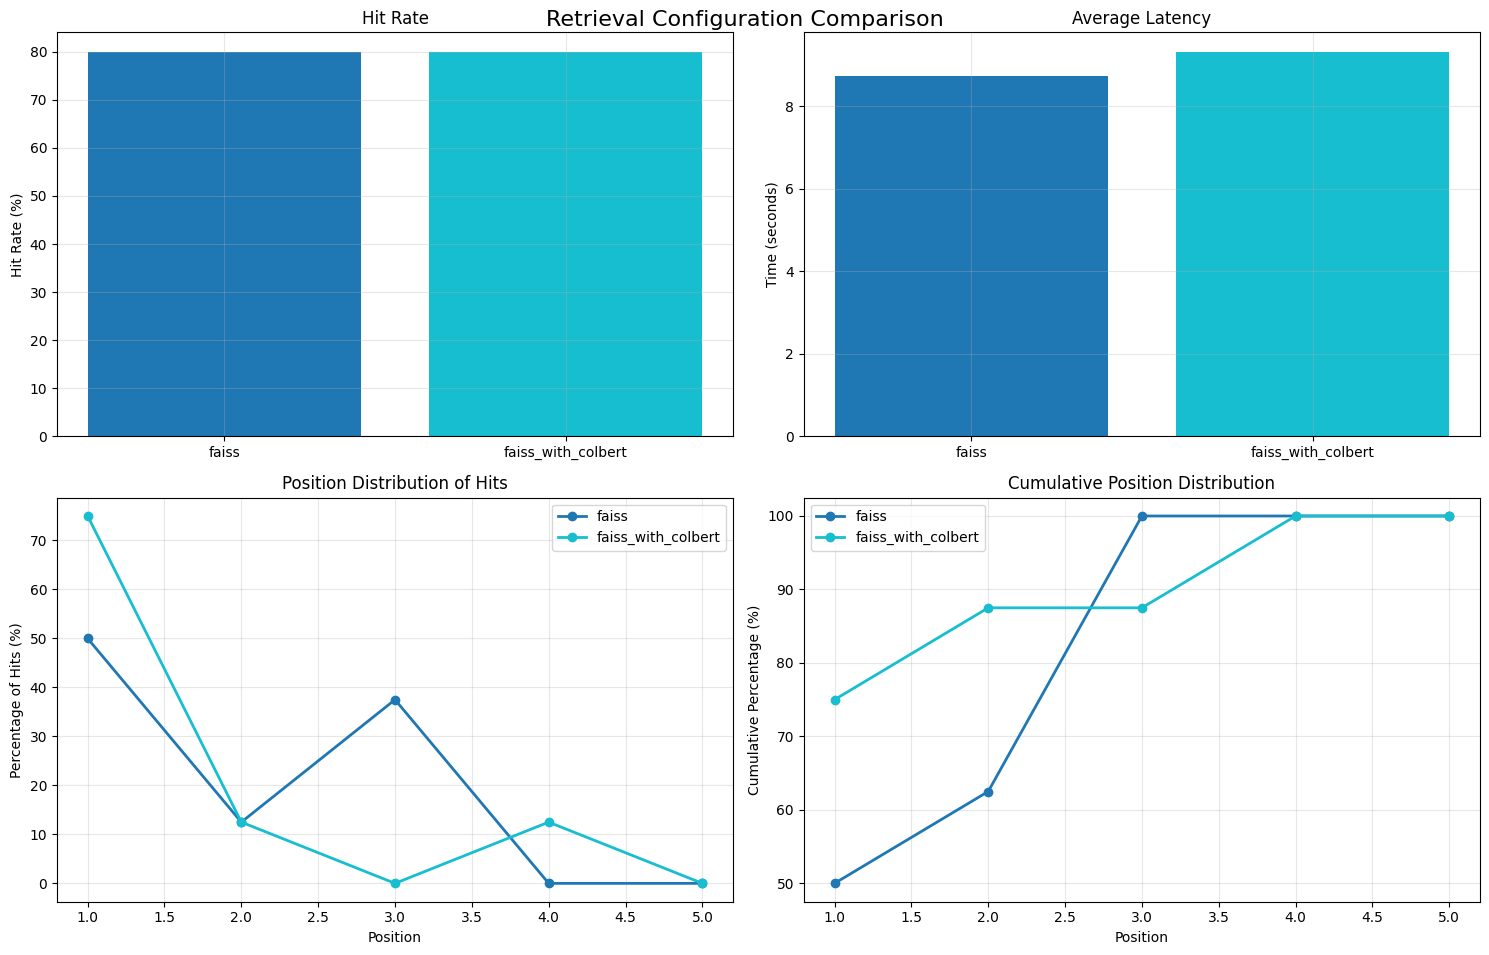

In [ ]:
fig = visualize_retrieval_metrics(base_metrics, colbert_metrics)
plt.show()

# Asssembling it All!

In [ ]:
def rag_pipeline(
        question: str,
        vectorstore: FAISS,
        reranker: Optional[RAGPretrainedModel] = None,
        num_retrieved_docs: int = 30,
        num_docs_final: int = 5):
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = vectorstore.similarity_search(query=question, k=num_retrieved_docs)
    relevant_docs = [doc.page_content for doc in relevant_docs]

     # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join([f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs